**Пути к директориям и файлам**

In [1]:
import pandas as pd
import numpy as np
import pickle
import random
from pathlib import Path
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, 
                             precision_recall_curve, recall_score,
                             plot_roc_curve
                            )
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# для отображения чисел с плавающей точкой без +е выполним следующий код: 
matplotlib.rcParams.update({'font.size': 14}) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

**Пути к директориям и файлам**

In [4]:
DATASET_PATH = './data/train.csv'
TEST_DATASET_PATH = './data/test.csv'
MODEL_FILE_PATH = './model.pkl'
# PREP_DATASET_PATH = './data/training_project/training_project_data_prep.csv'

**Задача**

Предсказать факт невыполнения кредитных обязательств

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Функции

In [5]:
def preprocess_outlier(df, col, threshold):    
    df.loc[df[col] > threshold, col] = np.nan
    return df

def corr(df, target):
    df_copy = df
    df_copy['target'] = df_copy[target]
    del df_copy[target]

    corr_with_target = df_copy.corr().iloc[:-1, -1].sort_values(ascending=False)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
    plt.title('Correlation with target variable')
    plt.show()
    
def hist(df, feature):    
    plt.figure(figsize = (16, 8))

    df[feature].hist(bins=30)
    plt.ylabel('Count')
    plt.xlabel(feature)

    plt.title(feature + 'distribution')
    plt.show()
    
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

### Загрузка данных

In [6]:
test_df = pd.read_csv(TEST_DATASET_PATH)
train_df = pd.read_csv(DATASET_PATH)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.000,NaN,0.000,11.000,26.300,685960.000,1.000,nan,1.000,debt consolidation,Short Term,99999999.000,47386.000,7914.000,749.000,0
1,Own Home,1025487.000,10+ years,0.000,15.000,15.300,1181730.000,0.000,nan,0.000,debt consolidation,Long Term,264968.000,394972.000,18373.000,737.000,1
2,Home Mortgage,751412.000,8 years,0.000,11.000,35.000,1182434.000,0.000,nan,0.000,debt consolidation,Short Term,99999999.000,308389.000,13651.000,742.000,0
3,Own Home,805068.000,6 years,0.000,8.000,22.500,147400.000,1.000,nan,1.000,debt consolidation,Short Term,121396.000,95855.000,11338.000,694.000,0
4,Rent,776264.000,8 years,0.000,13.000,13.600,385836.000,1.000,nan,0.000,debt consolidation,Short Term,125840.000,93309.000,7180.000,719.000,0


In [7]:
#train_df = pd.read_csv(TEST_DATASET_PATH)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### Обзор данных

In [9]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = ['Home Ownership', 
                      'Annual Income',
                      'Years in current job',
                      'Tax Liens',
                      'Number of Open Accounts',
                      'Years of Credit History',
                      'Maximum Open Credit',
                      'Number of Credit Problems',
                      'Months since last delinquent',
                      'Bankruptcies',
                      'Purpose',
                      'Term',
                      'Current Loan Amount',
                      'Current Credit Balance',
                      'Monthly Debt',
                      'Credit Score',
                     ]

NUM_FEATURE_NAMES = ['Annual Income',
                     'Tax Liens',
                     'Number of Open Accounts',
                     'Years of Credit History',
                     'Maximum Open Credit',
                     'Number of Credit Problems',
                     'Months since last delinquent',
                     'Bankruptcies',
                     'Current Loan Amount',
                     'Current Credit Balance',
                     'Monthly Debt',
                     'Credit Score',
                    ]

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

**Обзор целевой переменной**

In [10]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [11]:
# Видим явный дисбаланс классов

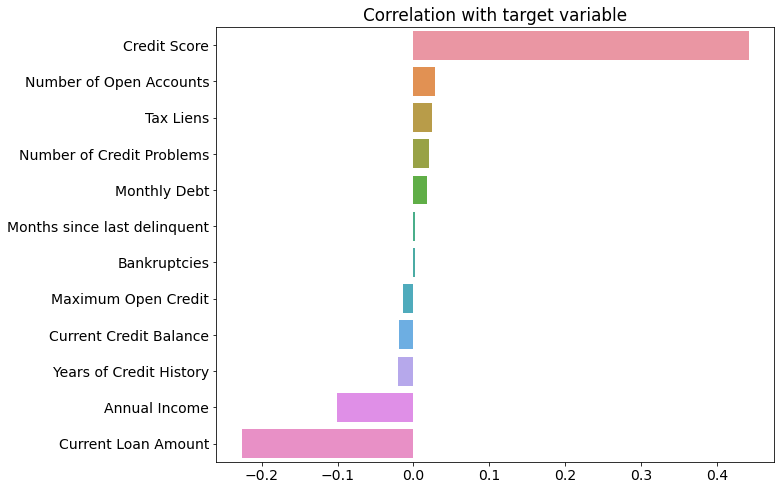

In [12]:
corr_with_target = train_df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [13]:
# Видим наибольшую корреляцию с признаками: Credit Score, Current Loan Amount, Annual Income.

**Обзор количественных признаков**

In [14]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.000,7500.000,7500.000,7500.000,7500.000,7500.000,3419.000,7486.000,7500.000,7500.000,7500.000,5943.000,7500.000
mean,1366391.720,0.030,11.131,18.317,945153.727,0.170,34.693,0.117,11873177.445,289833.235,18314.454,1151.087,0.282
std,845339.200,0.272,4.909,7.042,16026216.671,0.499,21.689,0.347,31926122.975,317871.382,11926.765,1604.451,0.450
min,164597.000,0.000,2.000,4.000,0.000,0.000,0.000,0.000,11242.000,0.000,0.000,585.000,0.000
25%,844341.000,0.000,8.000,13.500,279229.500,0.000,16.000,0.000,180169.000,114256.500,10067.500,711.000,0.000
50%,1168386.000,0.000,10.000,17.000,478159.000,0.000,32.000,0.000,309573.000,209323.000,16076.500,731.000,0.000
75%,1640137.000,0.000,14.000,21.800,793501.500,0.000,50.000,0.000,519882.000,360406.250,23818.000,743.000,1.000
max,10149344.000,7.000,43.000,57.700,1304726170.000,7.000,118.000,4.000,99999999.000,6506797.000,136679.000,7510.000,1.000


In [15]:
# Видим явные выбросы в Current Loan Amount

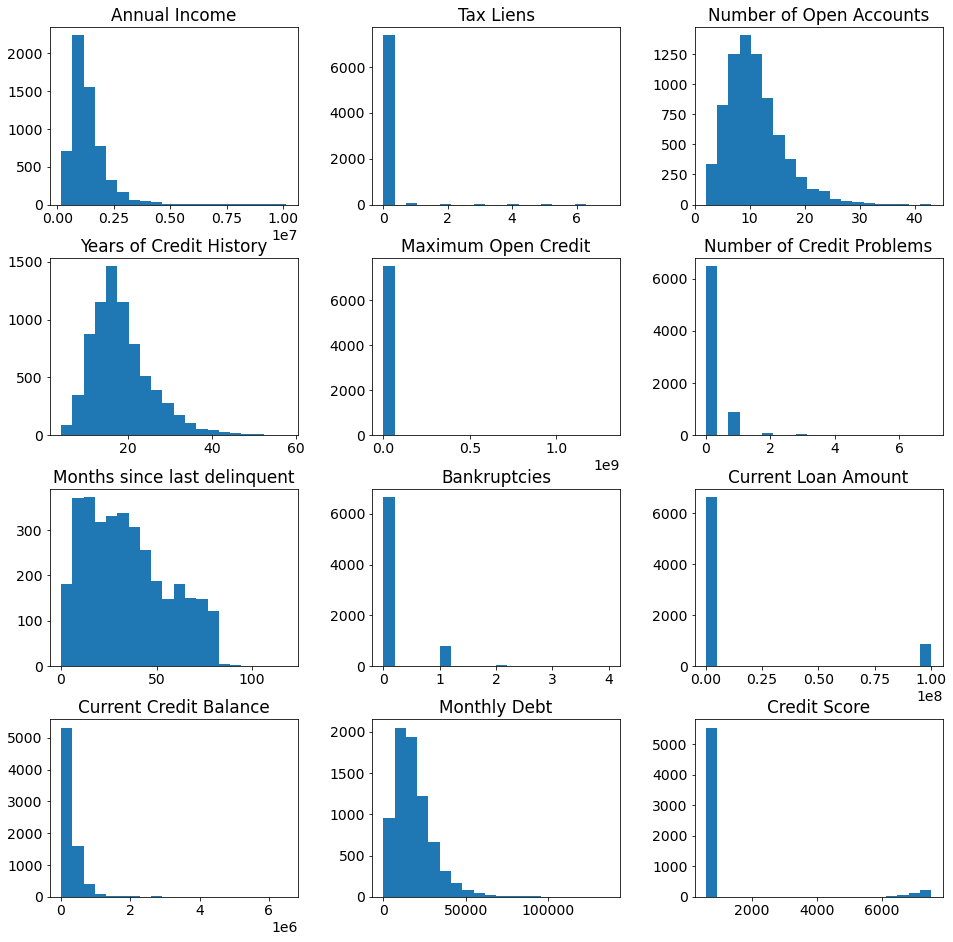

In [16]:
train_df[NUM_FEATURE_NAMES].hist(figsize=(16,16), bins=20, grid=False);

In [17]:
# Видим выбросы в Maximum Open Credit, Current Loan Amount, Credit Score

**Обзор категориальных признаков**

In [18]:
train_df.select_dtypes(include='object').columns

Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')

In [19]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### Обработка выбросов

In [20]:
# Я планирую в тех данных, в которых уже присутствуют пропуски, все выбросы заменить на NaN, 
# чтобы потом их более тщательно проработать

In [21]:
NUM_FEATURE_NAMES

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

**Annual Income**

In [22]:
train_df['Annual Income'].isna().sum()

1557

In [23]:
train_df['Annual Income'].describe()

count       5943.000
mean     1366391.720
std       845339.200
min       164597.000
25%       844341.000
50%      1168386.000
75%      1640137.000
max     10149344.000
Name: Annual Income, dtype: float64

In [24]:
# Неизвестно, в каких деньгах измеряется доход, но на мой взгляд, нижняя граница адекватная
# Судя по разнице между средним и медианой, есть небольшой сдвиг в правую сторону. 
# Поэтому я ограничу вернхнюю границу по 75% квантилю

In [25]:
quantile = train_df['Annual Income'].quantile(q=0.75)

In [26]:
feature_name = 'Annual Income'
train_df = preprocess_outlier(train_df, feature_name, quantile)

train_df[feature_name].isna().sum()

3043

In [27]:
train_df['Annual Income'].describe()

count      4457.000
mean    1012798.432
std      330686.293
min      164597.000
25%      759392.000
50%      999039.000
75%     1278225.000
max     1640042.000
Name: Annual Income, dtype: float64

**Tax Liens**

In [28]:
train_df['Tax Liens'].value_counts()

0.000    7366
1.000      83
2.000      30
3.000      10
4.000       6
5.000       2
6.000       2
7.000       1
Name: Tax Liens, dtype: int64

In [29]:
# Обрабатывать не буду, но в дальнейшем из этого признака можно создать новый: is_tax_liens

**Maximum Open Credit**

In [30]:
train_df['Maximum Open Credit'].describe()

count         7500.000
mean        945153.727
std       16026216.671
min              0.000
25%         279229.500
50%         478159.000
75%         793501.500
max     1304726170.000
Name: Maximum Open Credit, dtype: float64

In [31]:
# Здесь явно видно очень большое значение максимального показателя. Посмотрим, единичный ли это показатель.

In [32]:
train_df['Maximum Open Credit'].sort_values().tail(10)

3170     18683808.000
5731     19280426.000
5523     21372428.000
4769     26343328.000
7026     26406996.000
2763     40923894.000
2023     57562560.000
2617    265512874.000
44      380052288.000
617    1304726170.000
Name: Maximum Open Credit, dtype: float64

In [33]:
train_df['Maximum Open Credit'].isna().sum()

0

In [34]:
# Поскольку в данных нет пропусков, отсечём здесь совсем небольшую часть выборки и заменим на медиану

In [35]:
quantile = train_df['Maximum Open Credit'].quantile(q=0.98)
train_df.loc[train_df['Maximum Open Credit'] > quantile, 'Maximum Open Credit'] = train_df['Maximum Open Credit'].median()

In [36]:
train_df['Maximum Open Credit'].describe()

count      7500.000
mean     579971.501
std      426201.758
min           0.000
25%      279229.500
50%      478153.500
75%      761332.000
max     2448534.000
Name: Maximum Open Credit, dtype: float64

**Current Loan Amount**

In [37]:
train_df['Current Loan Amount'].describe()

count       7500.000
mean    11873177.445
std     31926122.975
min        11242.000
25%       180169.000
50%       309573.000
75%       519882.000
max     99999999.000
Name: Current Loan Amount, dtype: float64

In [38]:
train_df['Current Loan Amount'].isna().sum()

0

In [39]:
# Здесь какие-то неадекватные значения в max, построим гистограмму.

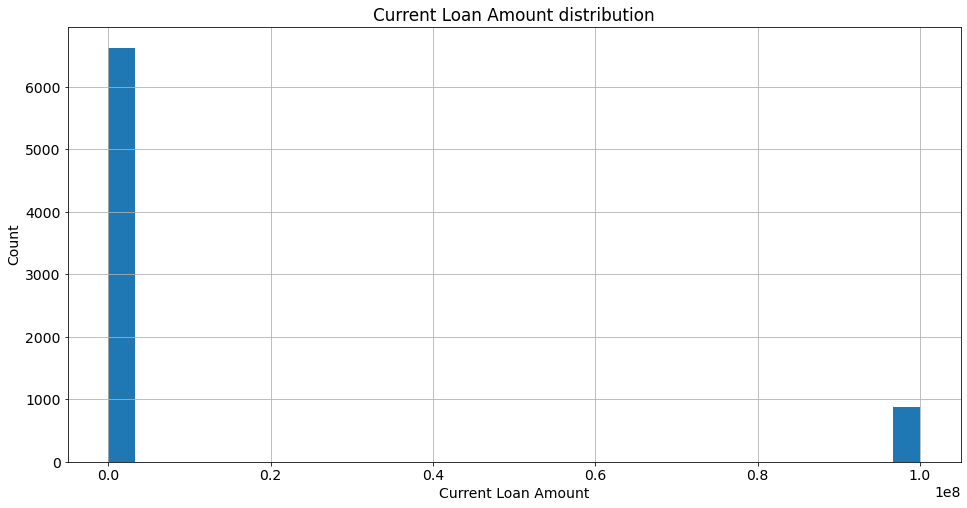

In [40]:
plt.figure(figsize = (16, 8))

train_df['Current Loan Amount'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Current Loan Amount')

plt.title('Current Loan Amount distribution')
plt.show()

In [41]:
# Предположу, что значением 99999999 заменили пропуск. Для нас этот признак очень важен, поэтому выделим 
# выбросы как отдельный признак. Что делать с выбросами, пока не знаем, поэтому заменю значения на Nan и посмотрю количество.

In [42]:
trashhold = 90000000
feature_name = 'Current Loan Amount'

train_df = preprocess_outlier(train_df, feature_name, trashhold)
train_df[feature_name].isna().sum()

870

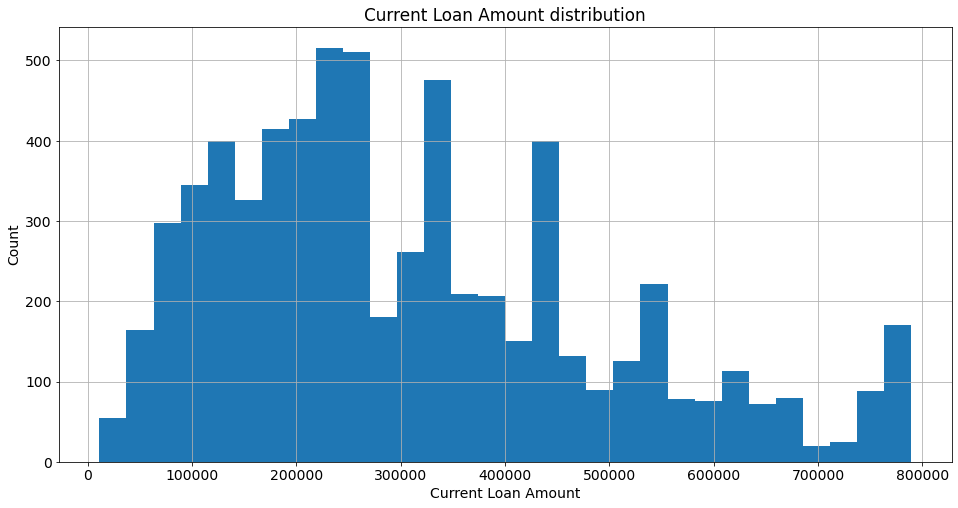

In [43]:
plt.figure(figsize = (16, 8))

train_df['Current Loan Amount'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Current Loan Amount')

plt.title('Current Loan Amount distribution')
plt.show()

In [44]:
train_df['current_loan_amount_nan'] = 0
train_df.loc[(train_df['Current Loan Amount'].isnull()), 'current_loan_amount_nan'] = 1

In [45]:
train_df['current_loan_amount_nan'].value_counts()

0    6630
1     870
Name: current_loan_amount_nan, dtype: int64

**Current Credit Balance**

In [46]:
train_df['Current Credit Balance'].describe()

count      7500.000
mean     289833.235
std      317871.382
min           0.000
25%      114256.500
50%      209323.000
75%      360406.250
max     6506797.000
Name: Current Credit Balance, dtype: float64

In [47]:
# Обработаем только самые большие значения
quantile = train_df['Current Credit Balance'].quantile(q=0.99)
train_df.loc[train_df['Current Credit Balance'] > quantile, \
             'Current Credit Balance'] = train_df['Current Credit Balance'].median()

In [48]:
train_df['Current Credit Balance'].describe()

count      7500.000
mean     268542.856
std      225117.204
min           0.000
25%      114256.500
50%      209313.500
75%      350887.250
max     1483026.000
Name: Current Credit Balance, dtype: float64

**Credit Score**

In [49]:
train_df['Credit Score'].describe()

count   5943.000
mean    1151.087
std     1604.451
min      585.000
25%      711.000
50%      731.000
75%      743.000
max     7510.000
Name: Credit Score, dtype: float64

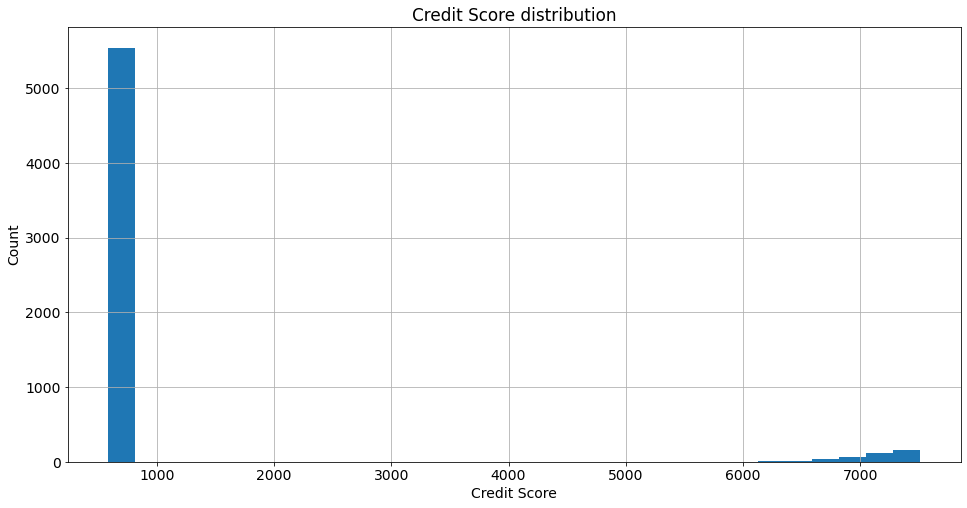

In [50]:
plt.figure(figsize = (16, 8))

train_df['Credit Score'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Credit Score')

plt.title('Credit Score distribution')
plt.show()

In [51]:
# Непонятно, что обозначает этот признак, поэтому пока оставлю без изменений. 
# После обработки пропусков отмечу в отдельном признаке эти значения.

### Обработка категориальных признаков

In [52]:
CAT_FEATURE_NAMES

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

**Home Ownership**

In [53]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [54]:
# Приму, что Home Mortgage и Have Mortgage обозначают одно и тоже и соединю эти признаки, чтобы сократить количество.

In [55]:
train_df.loc[train_df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

In [56]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3649
Rent             3204
Own Home          647
Name: Home Ownership, dtype: int64

In [57]:
# Создам дамми переменные на основе данного признака

In [58]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Home Ownership'])], axis=1)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,current_loan_amount_nan,Home Mortgage,Own Home,Rent
0,Own Home,482087.000,NaN,0.000,11.000,26.300,685960.000,1.000,nan,1.000,...,Short Term,nan,47386.000,7914.000,749.000,0,1,0,1,0
1,Own Home,1025487.000,10+ years,0.000,15.000,15.300,1181730.000,0.000,nan,0.000,...,Long Term,264968.000,394972.000,18373.000,737.000,1,0,0,1,0
2,Home Mortgage,751412.000,8 years,0.000,11.000,35.000,1182434.000,0.000,nan,0.000,...,Short Term,nan,308389.000,13651.000,742.000,0,1,1,0,0
3,Own Home,805068.000,6 years,0.000,8.000,22.500,147400.000,1.000,nan,1.000,...,Short Term,121396.000,95855.000,11338.000,694.000,0,0,0,1,0
4,Rent,776264.000,8 years,0.000,13.000,13.600,385836.000,1.000,nan,0.000,...,Short Term,125840.000,93309.000,7180.000,719.000,0,0,0,0,1


**Term**

In [59]:
train_df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [60]:
# Поскольку здесь всего две категории, создадим бинарный признак.

In [61]:
train_df['is_long_term'] = 0
train_df.loc[train_df['Term'] == 'Long Term', 'is_long_term'] = 1
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,current_loan_amount_nan,Home Mortgage,Own Home,Rent,is_long_term
0,Own Home,482087.000,NaN,0.000,11.000,26.300,685960.000,1.000,nan,1.000,...,nan,47386.000,7914.000,749.000,0,1,0,1,0,0
1,Own Home,1025487.000,10+ years,0.000,15.000,15.300,1181730.000,0.000,nan,0.000,...,264968.000,394972.000,18373.000,737.000,1,0,0,1,0,1
2,Home Mortgage,751412.000,8 years,0.000,11.000,35.000,1182434.000,0.000,nan,0.000,...,nan,308389.000,13651.000,742.000,0,1,1,0,0,0
3,Own Home,805068.000,6 years,0.000,8.000,22.500,147400.000,1.000,nan,1.000,...,121396.000,95855.000,11338.000,694.000,0,0,0,1,0,0
4,Rent,776264.000,8 years,0.000,13.000,13.600,385836.000,1.000,nan,0.000,...,125840.000,93309.000,7180.000,719.000,0,0,0,0,1,0


**Years in current job**

In [62]:
train_df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [63]:
train_df['Years in current job'].isna().sum()

371

In [64]:
# Выразим данный признак через другой, количественный. Попробуем найти медиану Current Loan Amount по каждой категории.

In [65]:
# Для начала отбросим все нулевые значения Current Loan Amount, чтобы данные были чище.

In [66]:
train_df_copy = train_df.copy()

In [67]:
train_df_copy['Current Loan Amount'].isna().sum()

870

In [68]:
train_df_copy.dropna(subset=['Current Loan Amount'], inplace=True)
train_df_copy.dropna(subset=['Years in current job'], inplace=True)

In [69]:
train_df_copy['Current Loan Amount'].isna().sum()

0

In [70]:
train_df_copy.shape

(6300, 22)

In [71]:
df_loan_amount = train_df_copy.groupby('Years in current job', 
                                       as_index=False).median()[['Years in current job', 'Current Loan Amount']]
df_loan_amount = pd.DataFrame(df_loan_amount)

In [72]:
df_loan_amount.rename(columns={'Current Loan Amount': 'median_loan_amount_per_years'}, inplace=True)
df_loan_amount

,Years in current job,median_loan_amount_per_years
0,1 year,232364.000
1,10+ years,313665.000
2,2 years,241648.000
3,3 years,259138.000
4,4 years,262262.000
5,5 years,262768.000
6,6 years,273856.000
7,7 years,276870.000
8,8 years,290642.000
9,9 years,298661.000


In [73]:
df_loan_amount.isna().sum()

Years in current job            0
median_loan_amount_per_years    0
dtype: int64

In [74]:
# Теперь заполним пропуски в признаке Years in current job основного датасета модой

In [75]:
 train_df['Years in current job'] = train_df['Years in current job'].fillna(train_df['Years in current job'].mode()[0])

In [76]:
# И добавим новые признаки в основной датасет

In [77]:
df_loan_amount

,Years in current job,median_loan_amount_per_years
0,1 year,232364.000
1,10+ years,313665.000
2,2 years,241648.000
3,3 years,259138.000
4,4 years,262262.000
5,5 years,262768.000
6,6 years,273856.000
7,7 years,276870.000
8,8 years,290642.000
9,9 years,298661.000


In [78]:
df_loan_amount.sort_values(by='median_loan_amount_per_years')

,Years in current job,median_loan_amount_per_years
10,< 1 year,224554.000
0,1 year,232364.000
2,2 years,241648.000
3,3 years,259138.000
4,4 years,262262.000
5,5 years,262768.000
6,6 years,273856.000
7,7 years,276870.000
8,8 years,290642.000
9,9 years,298661.000


In [79]:
train_df = train_df.merge(df_loan_amount, on='Years in current job')
train_df.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,current_loan_amount_nan,Home Mortgage,Own Home,Rent,is_long_term,median_loan_amount_per_years
0,Own Home,482087.000,10+ years,0.000,11.000,26.300,685960.000,1.000,nan,1.000,...,47386.000,7914.000,749.000,0,1,0,1,0,0,313665.000
1,Own Home,1025487.000,10+ years,0.000,15.000,15.300,1181730.000,0.000,nan,0.000,...,394972.000,18373.000,737.000,1,0,0,1,0,1,313665.000
2,Home Mortgage,1511108.000,10+ years,0.000,9.000,20.300,388124.000,0.000,73.000,0.000,...,51623.000,2317.000,745.000,0,1,1,0,0,0,313665.000
3,Rent,1040060.000,10+ years,0.000,13.000,12.000,330374.000,0.000,18.000,0.000,...,89015.000,19761.000,705.000,1,0,0,0,1,0,313665.000
4,Home Mortgage,933432.000,10+ years,0.000,8.000,14.000,443608.000,0.000,nan,0.000,...,315305.000,19446.000,706.000,0,0,1,0,0,0,313665.000


In [80]:
train_df.shape

(7500, 23)

**Purpose**

In [81]:
train_df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [82]:
# У меня совсем мало данных в строке renewable energy, поэтому я их добавлю в other.

In [83]:
if 'renewable energy' in train_df['Purpose'].value_counts():
            train_df.loc[train_df['Purpose'] == 'renewable energy', 'Purpose'] = 'other'

In [84]:
train_df['Purpose'].value_counts()

debt consolidation      5944
other                    667
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
Name: Purpose, dtype: int64

In [85]:
# Также выразим через другой признак

In [86]:
train_df_copy = train_df.copy()
train_df_copy.dropna(subset=['Annual Income'], inplace=True)
df_annual_income = train_df_copy.groupby('Purpose', 
                                       as_index=False).median()[['Purpose', 'Annual Income']]

In [87]:
df_annual_income.rename(columns={'Annual Income': 'median_income_per_purpose'}, inplace=True)
train_df = train_df.merge(df_annual_income, on='Purpose')


In [88]:
train_df.shape

(7500, 24)

In [89]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 7499
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 4457 non-null   float64
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           6630 non-null   float64
 13  Cur

### Обработка пропусков

In [90]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   3043
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount              870
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
current_loan_amount_nan            0
Home Mortgage                      0
Own Home                           0
Rent                               0
is_long_term                       0
median_loan_amount_per_years       0
median_income_per_purpose          0
dtype: int64

**Annual Income**

In [91]:
# Заполним пропуски медианой, создадим признак с отмеченными пропусками

In [92]:
train_df['annual_income_nan'] = 0
train_df.loc[(train_df['Annual Income'].isnull()), 'annual_income_nan'] = 1

In [93]:
train_df['Annual Income'] = train_df['Annual Income'].fillna(train_df['Annual Income'].median())

**Months since last delinquent**

In [94]:
# Поскольку очень много пропусков в этом признаке, предположим, что NaN означает отсутствие просрочки. 
# Создадим бинарный признак.

In [95]:
# is_delinquent
train_df['is_delinquent'] = 1
train_df.loc[train_df['Months since last delinquent'].isna(), 'is_delinquent'] = 0

**Bankruptcies**

In [96]:
train_df['Bankruptcies'] = train_df['Bankruptcies'].fillna(train_df['Bankruptcies'].mode()[0])

**Current Loan Amount**

In [97]:
train_df['Current Loan Amount'] = train_df['Current Loan Amount'].fillna(train_df['Current Loan Amount'].median())

**Credit Score**

In [98]:
train_df['credit_score_nan'] = 0
train_df.loc[train_df['Credit Score'].isna(), 'credit_score_nan'] = 1

In [99]:
train_df['Credit Score'] = train_df['Credit Score'].fillna(train_df['Credit Score'].median())

In [100]:
train_df['credit_score_over'] = 0
train_df.loc[(train_df['Credit Score'] > 1000), 'credit_score_over'] = 1

In [101]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                      0
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                       0
Credit Default                     0
current_loan_amount_nan            0
Home Mortgage                      0
Own Home                           0
Rent                               0
is_long_term                       0
median_loan_amount_per_years       0
median_income_per_purpose          0
annual_income_nan                  0
is_delinquent                      0
credit_score_nan                   0
c

### Генерирование новых фичей

**ratio_income_dept**

In [102]:
# В этой фиче я считаю, каково соотношение годового дохода к текущему долгу

In [103]:
train_df['ratio_income_dept'] = train_df['Annual Income'] / train_df['Current Loan Amount']      

**ratio_income_dept_per_month**

In [104]:
# Тоже самое, только за месяц

In [105]:
train_df['ratio_income_dept_per_month'] = train_df['Annual Income']/12/train_df['Monthly Debt']
  

**has_problems**

In [106]:
# Бинарная переменная, которая указывает, в каких наблюдениях Number of Credit Problems не равно 0

In [107]:
train_df['has_problems'] = 1
train_df.loc[train_df['Number of Credit Problems'] == 0, 'has_problems'] = 0

**has_tax_liens**

In [108]:
# Бинарная переменная, которая указывает, в каких наблюдениях Tax Liens не равно 0

In [109]:
train_df['has_tax_liens'] = 1
train_df.loc[train_df['Tax Liens'] == 0, 'has_tax_liens'] = 0

In [110]:
# Аналогично для Bankruptcies

In [111]:
train_df['is_bankruptcy'] = 0
train_df.loc[train_df['Bankruptcies'] != 0, 'is_bankruptcy'] = 1

### Матрица корреляций

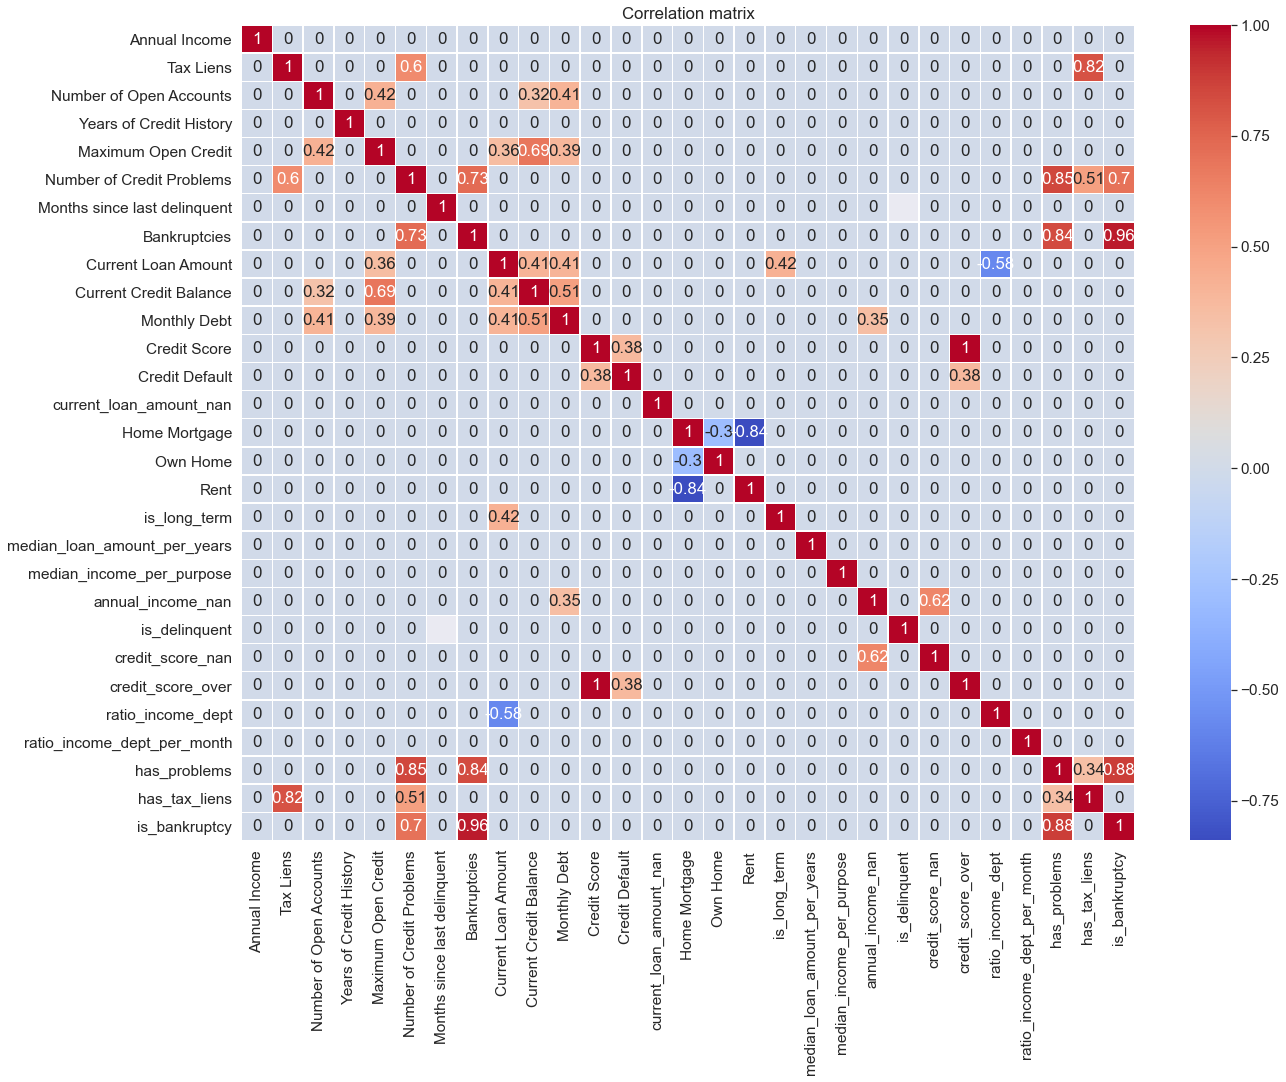

In [112]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [113]:
# Мало корреляций с целевой переменной. В основном по признаку Credit Score

In [114]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.mode=None
        self.medians=None
        self.kitchen_square_quantile = None
        self.x_copy=None
        self.x_copy_2=None
        
        self.df_annual_income=None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.mode = X.mode()
        self.medians = X.median()
        self.annual_income_quantile = X['Annual Income'].quantile(q=0.75)
        self.open_credit_quantile = X['Maximum Open Credit'].quantile(q=0.98)
        self.credit_balance_quantile = X['Current Credit Balance'].quantile(q=0.99)  
        
        
        
         
    
    def transform(self, X):
        """Трансформация данных"""
        
        X = X.copy()
        
                
        # Количественные признаки
        
        # Annual Income        
        feature_name = 'Annual Income'
        X = preprocess_outlier(X, feature_name, self.annual_income_quantile)

        
        # Maximum Open Credit       
        X.loc[X['Maximum Open Credit'] > self.open_credit_quantile, 'Maximum Open Credit'] = self.medians['Maximum Open Credit']
        
               
        # Current Loan Amount
        trashhold = 90000000
        feature_name = 'Current Loan Amount'

        X = preprocess_outlier(X, feature_name, trashhold)
        X[feature_name].isna().sum()
        
       
        X['current_loan_amount_nan'] = 0
        X.loc[(X['Current Loan Amount'].isnull()), 'current_loan_amount_nan'] = 1

        
        # Current Credit Balance        
        X.loc[X['Current Credit Balance'] > self.credit_balance_quantile, \
             'Current Credit Balance'] = self.medians['Current Credit Balance']
        
        
        # Категориальные признаки
        
        
        # Home Ownership
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'])], axis=1)
        
        
        # Term
        X['is_long_term'] = 0
        X.loc[X['Term'] == 'Long Term', 'is_long_term'] = 1
        
        # Years in current job
        
        self.x_copy_2 = X.copy()
        
        self.x_copy_2.dropna(subset=['Current Loan Amount'], inplace=True)
        self.x_copy_2.dropna(subset=['Years in current job'], inplace=True)
        
        df_loan_amount = self.x_copy_2.groupby('Years in current job', \
                         as_index=False).median()[['Years in current job', 'Current Loan Amount']]        
        df_loan_amount = pd.DataFrame(df_loan_amount)
        df_loan_amount.rename(columns={'Current Loan Amount': 'median_loan_amount_per_years'}, inplace=True)
        
        X['Years in current job'] = X['Years in current job'].fillna(self.mode['Years in current job'][0])
        
        X = X.merge(df_loan_amount, on='Years in current job')
       
        
        
        # Purpose
        if 'renewable energy' in X['Purpose'].value_counts():
            X.loc[X['Purpose'] == 'renewable energy', 'Purpose'] = 'other'
        
               
       
        self.x_copy = X.copy()
        
        self.x_copy.dropna(subset=['Annual Income'], inplace=True)
        
        self.df_annual_income = self.x_copy.groupby('Purpose', as_index=False).median()[['Purpose', 'Annual Income']]
        self.df_annual_income.rename(columns={'Annual Income': 'median_income_per_purpose'}, inplace=True)
        
        X = X.merge(self.df_annual_income, on='Purpose')      
        
        
        
        # Обработка пропусков         
        
        # Annual Income
        X['annual_income_nan'] = 0
        X.loc[(X['Annual Income'].isnull()), 'annual_income_nan'] = 1
        X['Annual Income'] = X['Annual Income'].fillna(self.medians['Annual Income'])
        
        # Months since last delinquent
        X['is_delinquent'] = 1
        X.loc[X['Months since last delinquent'].isna(), 'is_delinquent'] = 0
        
        X.drop('Months since last delinquent', axis='columns', inplace=True)
        
        # Bankruptcies
        X['Bankruptcies'] = X['Bankruptcies'].fillna(self.mode['Bankruptcies'][0])
        
        # Current Loan Amount
        X['Current Loan Amount'] = X['Current Loan Amount'].fillna(self.medians['Current Loan Amount'])
        
        # Credit Score
        X['credit_score_nan'] = 0
        X.loc[X['Credit Score'].isna(), 'credit_score_nan'] = 1
        
        X['Credit Score'] = X['Credit Score'].fillna(self.medians['Credit Score'])
        
        X['credit_score_over'] = 0
        X.loc[(X['Credit Score'] > 1000), 'credit_score_over'] = 1       
        
        
        # Генерация новых фич #
        
        # has_problems        
        X['has_problems'] = 1
        X.loc[X['Number of Credit Problems'] == 0, 'has_problems'] = 0
        
        
        #has_tax_liens        
        X['has_tax_liens'] = 1
        X.loc[X['Tax Liens'] == 0, 'has_tax_liens'] = 0
        
        
        # is_bankruptcy        
        X['is_bankruptcy'] = 0
        X.loc[X['Bankruptcies'] != 0, 'is_bankruptcy'] = 1
        
        
        # ratio_income_dept        
        X['ratio_income_dept'] = X['Annual Income'] / X['Current Loan Amount']
        
        
        #ratio_income_dept_per_month
        X['ratio_income_dept_per_month'] = X['Annual Income']/12/X['Monthly Debt']
        
        return X

### Подготовка данных

In [115]:
train_df = pd.read_csv(DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [116]:
train_df = pd.read_csv(DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

preprocessor = DataPreprocessing()
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)
train_df.shape, test_df.shape

((7500, 32), (2500, 31))

In [117]:
train_df.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0)

**Отбор признаков**

In [118]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = [
                        'Home Ownership',
                        'Annual Income',
                        'Years in current job',
                        'Tax Liens',
                        'Number of Open Accounts',
                        'Years of Credit History',
                        'Maximum Open Credit',
                        'Number of Credit Problems',                        
                        'Bankruptcies',
                        'Purpose',
                        'Term',
                        'Current Loan Amount',
                        'Current Credit Balance',
                        'Monthly Debt',
                        'Credit Score',
                        'current_loan_amount_nan',
                        'Home Mortgage',
                        'Own Home',
                        'Rent',
                        'is_long_term',
                        'median_loan_amount_per_years',
                        'median_income_per_purpose',
                        'annual_income_nan',
                        'is_delinquent',
                        'credit_score_nan',
                        'credit_score_over',
                        'ratio_income_dept_per_month',
                        'ratio_income_dept',
                        'has_problems',
                        'has_tax_liens',
                        'is_bankruptcy',
                    ]

NUM_FEATURE_NAMES = [
                        'Annual Income',    
                        'Tax Liens',
                        'Number of Open Accounts',
                        'Years of Credit History',
                        'Maximum Open Credit',
                        'Number of Credit Problems',    
                        'Bankruptcies',    
                        'Current Loan Amount',
                        'Current Credit Balance',
                        'Monthly Debt',
                        'Credit Score',
                        'current_loan_amount_nan',
                        'Home Mortgage',
                        'Own Home',
                        'Rent',
                        'is_long_term',
                        'median_loan_amount_per_years',
                        'median_income_per_purpose',
                        'annual_income_nan',
                        'is_delinquent',
                        'credit_score_nan',
                        'credit_score_over',
                        'ratio_income_dept_per_month',
                        'ratio_income_dept',
                        'has_problems',
                        'has_tax_liens',
                        'is_bankruptcy',
                    ]

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

NEW_FEATURE_NAMES = [
                        'current_loan_amount_nan',
                        'Home Mortgage',
                        'Own Home',
                        'Rent',
                        'is_long_term',
                        'median_loan_amount_per_years',
                        'median_income_per_purpose',
                        'annual_income_nan',
                        'is_delinquent',
                        'credit_score_nan',
                        'credit_score_over',
                        'ratio_income_dept_per_month',
                        'ratio_income_dept',
                        'has_problems',
                        'has_tax_liens',
                        'is_bankruptcy',
                    ] 

**Разбиение на train и test**

In [119]:
X = train_df[NUM_FEATURE_NAMES]
y = train_df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.2,
                                                    random_state=21,
                                                    stratify=y)
X_train.shape, X_test.shape

((6000, 27), (1500, 27))

In [120]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5502958579881656

### CatBoost 

In [121]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=47,
                                     class_weights=[1, 2.5],
                                     eval_metric='F1',
                                     #cat_features=CAT_FEATURE_NAMES,
                                     early_stopping_rounds=100,
                                     use_best_model=True,
                                     depth=3,
                                     iterations=50
                                     )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.74      0.79      4310
           1       0.49      0.65      0.56      1690

    accuracy                           0.71      6000
   macro avg       0.67      0.69      0.67      6000
weighted avg       0.74      0.71      0.72      6000

TEST

              precision    recall  f1-score   support

           0       0.84      0.75      0.79      1077
           1       0.50      0.64      0.56       423

    accuracy                           0.72      1500
   macro avg       0.67      0.69      0.68      1500
weighted avg       0.75      0.72      0.73      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               804  273
1               151  272


**LGBMClassifier**

In [122]:
'''
%%time
model_lgbm = lgbm.LGBMClassifier(random_state=40, 
                                 class_weight={0:1, 1:disbalance},
                                 n_estimators=60,
                                 lambda_l1=0.8,
                                 lambda_l2=1.2,
                                 min_data_in_leaf=25,
                                 num_leaves=4,                                 
                                )
model_lgbm.fit(X_train, y_train)

evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)
'''

'\n%%time\nmodel_lgbm = lgbm.LGBMClassifier(random_state=40, \n                                 class_weight={0:1, 1:disbalance},\n                                 n_estimators=60,\n                                 lambda_l1=0.8,\n                                 lambda_l2=1.2,\n                                 min_data_in_leaf=25,\n                                 num_leaves=4,                                 \n                                )\nmodel_lgbm.fit(X_train, y_train)\n\nevaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)\n'

In [123]:
# В качестве лучшей модели я оставлю CatBoost

In [124]:
model_catb.best_score_

{'learn': {'Logloss': 0.5246555181555044, 'F1': 0.692816807334993},
 'validation': {'Logloss': 0.5346921428086202, 'F1': 0.6764486446157673}}

**Важность признака**

In [125]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_catb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
21,credit_score_over,40.676
11,current_loan_amount_nan,35.541
10,Credit Score,15.883
15,is_long_term,2.207
20,credit_score_nan,1.088
4,Maximum Open Credit,0.992
0,Annual Income,0.726
23,ratio_income_dept,0.714
12,Home Mortgage,0.420
22,ratio_income_dept_per_month,0.361


### Лучшая модель

In [133]:
frozen_params = {
    'silent':True, 
    'random_state':47,
    'class_weights':[1, 2.5],
    'eval_metric':'F1',    
    'early_stopping_rounds':100,
    'use_best_model':True,    
    'depth':3,
    'iterations':50
}

model_catb = catb.CatBoostClassifier(**frozen_params)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.74      0.79      4310
           1       0.49      0.65      0.56      1690

    accuracy                           0.71      6000
   macro avg       0.67      0.69      0.67      6000
weighted avg       0.74      0.71      0.72      6000

TEST

              precision    recall  f1-score   support

           0       0.84      0.75      0.79      1077
           1       0.50      0.64      0.56       423

    accuracy                           0.72      1500
   macro avg       0.67      0.69      0.68      1500
weighted avg       0.75      0.72      0.73      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               804  273
1               151  272


In [127]:
#with open(MODEL_FILE_PATH, 'wb') as file:
#    pickle.dump(model_catb, file)

### Прогнозирование на тестовом датасете

In [128]:
y_test_preds = model_catb.predict(X_test)

In [129]:
submit = pd.read_csv('data/sample_submission.csv')
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [130]:
predictions = model_catb.predict(test_df[NUM_FEATURE_NAMES])
predictions

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [131]:
submit['Credit Default'] = predictions
submit.head()

,Id,Credit Default
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0


In [132]:
submit.to_csv('gb_submit.csv', index=False)